In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np

from qiskit import Aer, AncillaRegister, ClassicalRegister, QuantumRegister, QuantumCircuit, execute
from qiskit.circuit import ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

from scipy.optimize import minimize

from qutip import Bloch, basis, ket, rx, ry, rz

%matplotlib inline

### Creating a general 1 qubit state

We should be able to reach any point on a unit sphere by varying just two parameters, angles $\theta$ and $\phi$. To verify that let us create a method that replicates the quantum circuit we employ further on, at the core of the Swap algorithm, as an ansatz of sorts.

In [4]:
def get_statevector(params):
    qc = QuantumCircuit(1)
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    
    backend = Aer.get_backend("statevector_simulator")
    
    job = execute(qc, backend)
    result = job.result()
    
    return result.get_statevector(qc)

The next two methods will help us check visually if we are on the right track.

In [5]:
def bloch_vector_from_angles(angles):
    return ry(angles[1]) * rx(angles[0]) * ket("0")

def bloch_vector_from_amplitudes(amplitudes):
    return amplitudes[0] * ket("0") + amplitudes[1] * ket("1")

Let us generate a number of pairs of random angles between $0$ and $2\pi$. Then we feed them through one of the helper methods above to generate states that we can plot on the Bloch sphere.

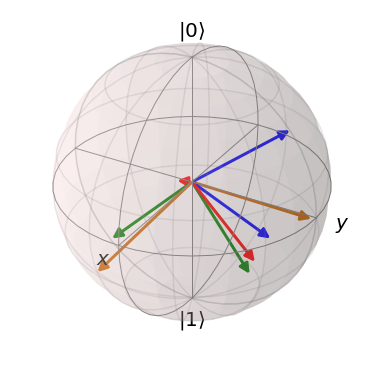

In [6]:
amplitudes = map(get_statevector, np.random.uniform(0, 2 * np.pi, (8, 2)))
b = Bloch()
b.add_states(map(bloch_vector_from_amplitudes, amplitudes))
b.show()

Indeed, using a pair of angles allows us to reach any point on the Bloch sphere.
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

### Swap test

Encouraged that a simple circuit with only two parameters can reconstruct any one-qubit state $\ket{\psi}$, we can now proceed and implement the Swap test circuit using this simple circuit. We pack into a class called `SwapTestCircuit` the creation of the circuit along with a method to evaluate it as well as some variables that we might want to keep close.

When we instanciate this class, we can pass the `target_state` target state that we want to approximate onto a probe state $\ket{\varphi}$. It is worth noting that `target_state` can be of shape $(N, 2)$, where $N$ is the number of qubits we want to use in the target state. The probe state will automatically be generated with $(N, 2)$ parameters. If `target_state` is not given, it will be generated randomly with angles $\theta, \phi \in \left[-\pi, \pi\right]$ and $N = 1$.

On the instance we can call the method `cost(probe_state)`, where `probe_state` must have the same shape as `target_state`, i.e. $(N, 2)$. This will calculate $1 - \left|\braket{\varphi}{\psi}\right|^2$, that is when $\ket{\varphi}$ and $\ket{\psi}$ are orthogonal `cost` will output 1, and if they are collinear—0, which makes it possible, by minimising `cost`, to approach collinearity.

In [7]:
class SwapTestCircuit:
    
    def __init__(self, backend, target_state=None, shots=1000):
        """Creates a circuit that can carry out the Swap test on two states of N qubits each.
        The number of qubits is inferred from the shape of target_state.

        Args:
            backend: The qiskit backend to use.
            target_state (numpy.ndarray): The state to compare against: an (N, 2) array,
                where N is the number of qubits. The state of each qubit is specified with 2
                parameters that correspond to the angles theta assigned to rotation gates
                Rx and Ry, respectively. If not given, a random 1 qubit state will be
                generated.
            shots (int): How many times to execute the circuit when ``cost`` is called.

        Attributes:
            num_qubits (int): The number of qubits per state.
            target_state ((N, 3) numpy.ndarray): The state to compare against.
            circuit: The generated Swap test circuit. 

        Methods:
            cost(probe_state):
                Runs the Swap test ``circuit`` ``shots`` number of times to
                compare ``target_state`` with ``probe_state``.

                probe_state ((N, 2) numpy.ndarray): the state to compare to ``target_state``,
                    where N is the number of qubits used in the state. Each row of the array
                    contains 2 angles theta that are assigned to rotation gates Rx and Ry,
                    respectively.

                Returns a float within [0, 1] that quantifies how far apart the two states
                are: 0 when the states are collinear, and 1 when they are orthogonal.
                That is, an approximation of: 1 - |<\phi|\psi>|^2
        """
        self._backend = backend
        self._shots = shots
        
        self.target_state = target_state       
        if target_state is None:
            self.target_state = np.random.uniform(-np.pi, np.pi, (1, 2))
        
        if len(self.target_state.shape) == 2:
            self.num_qubits = self.target_state.shape[0]
        else:
            self.num_qubits = 1
        
        pv = ParameterVector(u'θ', self.num_qubits * 2)
        self._params = np.array(pv.params).reshape(self.num_qubits, 2)

        self._create_swap_test_circuit()
        
    def _create_swap_test_circuit(self):
        target_register = QuantumRegister(self.num_qubits)
        probe_register = QuantumRegister(self.num_qubits)
        ancilla = AncillaRegister(1, 'ancilla')
        classical = ClassicalRegister(1)
        
        self.circuit = QuantumCircuit(ancilla, target_register, probe_register, classical)
        
        self.circuit.h(ancilla[0])
        
        for params, t_state, target_q, probe_q in zip(self._params, self.target_state,
                                                      target_register, probe_register):
            self.circuit.rx(t_state[0], target_q)
            self.circuit.ry(t_state[1], target_q)
            self.circuit.rx(params[0], probe_q)
            self.circuit.ry(params[1], probe_q)
            self.circuit.cswap(ancilla[0], probe_q, target_q)
            
        self.circuit.h(ancilla[0])
        self.circuit.measure(ancilla[0], classical)
        
        return self.circuit

    def cost(self, probe_state):
        """cost(probe_state):
                Runs the Swap test ``circuit`` ``shots`` number of times to
                compare ``target_state`` with ``probe_state``.

                probe_state ((N, 2) numpy.ndarray): the state to compare to ``target_state``,
                    where N is the number of qubits used in the state. Each row of the array
                    contains 2 angles theta that are assigned to rotation gates Rx and Ry,
                    respectively.

                Returns a float within [0, 1] that quantifies how far apart the two states
                are: 0 when the states are collinear, and 1 when they are orthogonal.
                That is, an approximation of: 1 - |<\phi|\psi>|^2
        """
        flat_param_values = probe_state.flatten()
        flat_params = self._params.flatten()
        
        if len(flat_param_values) != len(flat_params):
            raise KeyError(f"Got {len(flat_param_values)} values for " +
                           f"{len(flat_params)} parameters.")
        
        values = {param: value for param, value in zip(flat_params, flat_param_values)}
        
        circuit = self.circuit.assign_parameters(values)
        
        job = execute(circuit, self._backend, shots=self._shots)
        result = job.result()
        counts = result.get_counts(circuit)

        return (2.0 / self._shots) * counts['1'] if '1' in counts.keys() else 0

Let us create an instance of `SwapTestCircuit` in action and let qiskit draw it. We can see that the rotation gates on the target qubit have been assigned randomly generated angles but the probe qubit remains parameterized.

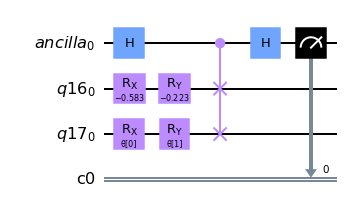

In [8]:
backend = Aer.get_backend("qasm_simulator")

swap_test = SwapTestCircuit(backend, shots=10000)
swap_test.circuit.draw("mpl")

Now we can see our `SwapTestCircuit` in action. We generate a random initial state to use as probe, and pass it along with the `cost` method to an optimizer.

In [9]:
initial_params = np.random.uniform(-np.pi, np.pi, (1, 2))
result = minimize(swap_test.cost, initial_params, method='COBYLA',
                  tol=1e-8, options={"maxiter": 1000})

It is time to check if we have succeeded approximating $\ket{\psi}$ with the probe state $\ket{\varphi}$. First, we make sure that when we feed the optimized parameters to `cost` we get reasonably low number.

In [10]:
swap_test.cost(result.x)

0.0004

We can also use the helper method, that we used in the beginning, to calculate $\left|\braket{\varphi}{\psi}\right|^2$ and check that it is close to 1.

In [11]:
states = np.array([swap_test.target_state.flatten(), result.x.flatten()])

phi = np.array(get_statevector(states[0]))
psi = np.array(get_statevector(states[1]))

np.abs(np.dot(phi.conjugate().T, psi))**2

0.9996060194786369

Finally, we can plot the target (orange) and probe (green) states on the Bloch sphere. This allows us to visualize how close the probe state has come to the target.

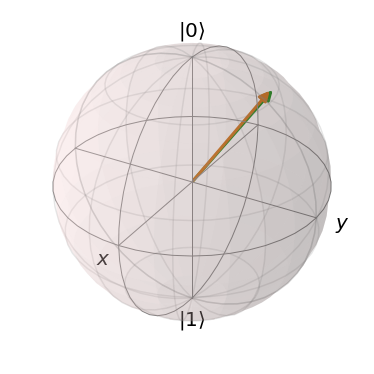

In [12]:
b = Bloch()
b.add_states(map(bloch_vector_from_angles, states))
b.show()

### Finding a product state using grid search

A product state has only one non-zero term in its expansion. That is, products such as $\ket{\psi} = \ket{1101}$ are product states. To reproduce such a state with our probe $\ket{\varphi}$, we can flip each of its qubits to either $\ket{0}$ or $\ket{1}$ in a combinatorial fashion until the Swap test show us that for one of those combinations $1 - |\braket{\varphi}{\psi}|^2$ is close to zero, which would mean that we have obtained the target state.

Since we are only interested in states that are either $\ket{0}$ or $\ket{1}$ and since $R_y(\theta=\pi)$ flips between these two states and we start with $\ket{0}$, we can encode a binary string that represents a product state as an array of angle pairs $\phi, \theta$. This way, $\phi$ will always be equal to $0$ because we do not want to rotate the state around $x$, and $\psi$ will be equal to either $0$ (when we want to encode $\ket{0}$) or $\pi$ (for $\ket{1}$). Having this encoding scheme in place, the grid search boils down to iterating $0$ through $2^N$ where $N$ is the number of qubits in the target state, and running the Swap test until the $N$-qubit probe state is found to be collinear with the target.

In [13]:
def product_state(product_state):   
    if isinstance(product_state, str) and all(x in ('0', '1') for x in product_state):
        target_product_state = np.zeros((len(product_state), 2))
        for i, q in enumerate(product_state):
            target_product_state[i] = [0, int(q) * np.pi]
        return target_product_state
    raise KeyError(f"{product_state} is not a binary string.")

def grid_search(cost_fn, target, tol=1e-4, steps=500):
    N_qubits = len(target)
    for i in range(2**N_qubits):
        bin_string = bin(i)[2:]
        candidate = '0' * (N_qubits - len(bin_string)) + bin_string
        if cost_fn(product_state(candidate)) < tol:
            return candidate
    raise RuntimeWarning("State not found. Try increasing tolerance.")

We generate randomly the target state and encode it as $R_y$ rotations.

In [14]:
target = product_state(bin(np.random.randint(0, 32))[2:])
target

array([[0.        , 3.14159265],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 3.14159265],
       [0.        , 3.14159265]])

Then we create an instance of `SwapTestCircuit` using our encoded target and, out of curiosity, we plot the generated circuit.

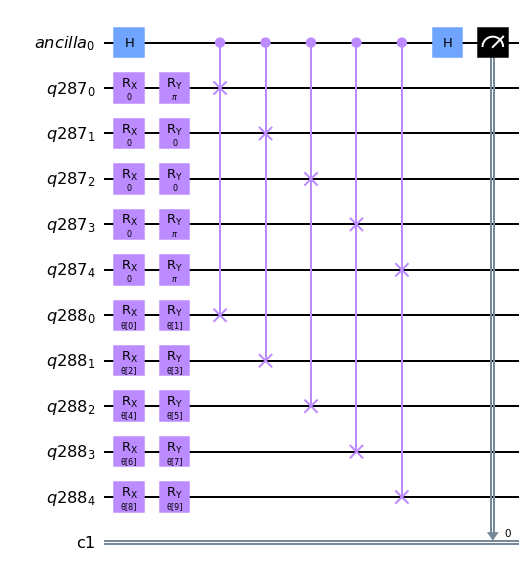

In [15]:
multi_swap_test = SwapTestCircuit(backend, target_state=target)
multi_swap_test.circuit.draw("mpl")

Finally, we run the grid search algorithm to find the target state.

In [16]:
grid_search(multi_swap_test.cost, target, steps=100)

'10011'

$$QED$$